**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Task](#toc2_)    
- [Load](#toc3_)    
- [EDA](#toc4_)    
  - [Процент завершивших](#toc4_1_)    
  - [Даты](#toc4_2_)    
  - [Триггерные группы](#toc4_3_)    
  - [Завершившие тест](#toc4_4_)    
  - [Конверсия по триггерам](#toc4_5_)    
- [Вывод](#toc5_)    
- [Дальнейшие исследования](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Imports](#toc0_)

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import math as mth
import scipy.stats as st


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 22

sns.set_style('darkgrid')
palette_dict = {1:'orange', 0: 'grey'}

DATE_END = '02-16 16:51:00'

# <a id='toc2_'></a>[Task](#toc0_)

В 2021-2022 году всем ученикам, которые писали тесты на платформе Летово Онлайн, рассылали триггерные рассылки, если они не завершали начатый тест к определенному сроку

- 1 триггер, если не завершали за сутки
- 2 триггер, если не завершали за первые 7 суток, т.е. на 8-е сутки приходил 2й триггер
- 3 триггер, если не завершали за первые 14 суток, т.е на 15-е сутки приходил 3й триггер

В 2022-2023 году всем ученикам перестали посылать триггерные рассылки.

Необходимо сравнить конверсии в завершение тестов, а также распределение завершивших по триггерным группам, чтобы выяснить есть ли разница в данных по двум годам.  

Тесты брались за каждый учебный год до 16.02 включительно и соотвественно и завершенными считались только тесты, которые были завершены к этому сроку.

# <a id='toc3_'></a>[Load](#toc0_)

In [30]:
df = pd.read_csv('tests_started_finished_2021-2023.csv', parse_dates=['started_at', 'finished_at']).sort_values(by='year')
display(df)
df.info()

,year,id,test_finished,started_at,finished_at
28688,2021-2022,1901,1,2021-09-11 13:39:46,2021-11-04 18:48:15.666
38243,2021-2022,32251,1,2021-11-05 15:40:22,2021-11-05 16:01:19.341
38244,2021-2022,32256,1,2021-11-05 15:45:32,2021-11-07 14:50:56.518
38245,2021-2022,32262,1,2021-11-05 15:50:41,2021-11-06 18:37:04.009
38246,2021-2022,32263,1,2021-11-05 15:50:44,2021-11-22 19:03:10.017
...,...,...,...,...,...
18460,2022-2023,27556,0,2022-12-04 14:05:02,NaT
18461,2022-2023,27557,0,2022-12-04 14:07:26,NaT
18462,2022-2023,27558,1,2022-12-04 14:10:33,2022-12-04 22:05:58.000
18451,2022-2023,27545,0,2022-12-04 13:35:42,NaT


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57377 entries, 28688 to 0
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   year           57377 non-null  object        
 1   id             57377 non-null  int64         
 2   test_finished  57377 non-null  int64         
 3   started_at     57377 non-null  datetime64[ns]
 4   finished_at    30151 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 2.6+ MB


# <a id='toc4_'></a>[EDA](#toc0_)

## <a id='toc4_1_'></a>[Процент завершивших](#toc0_)

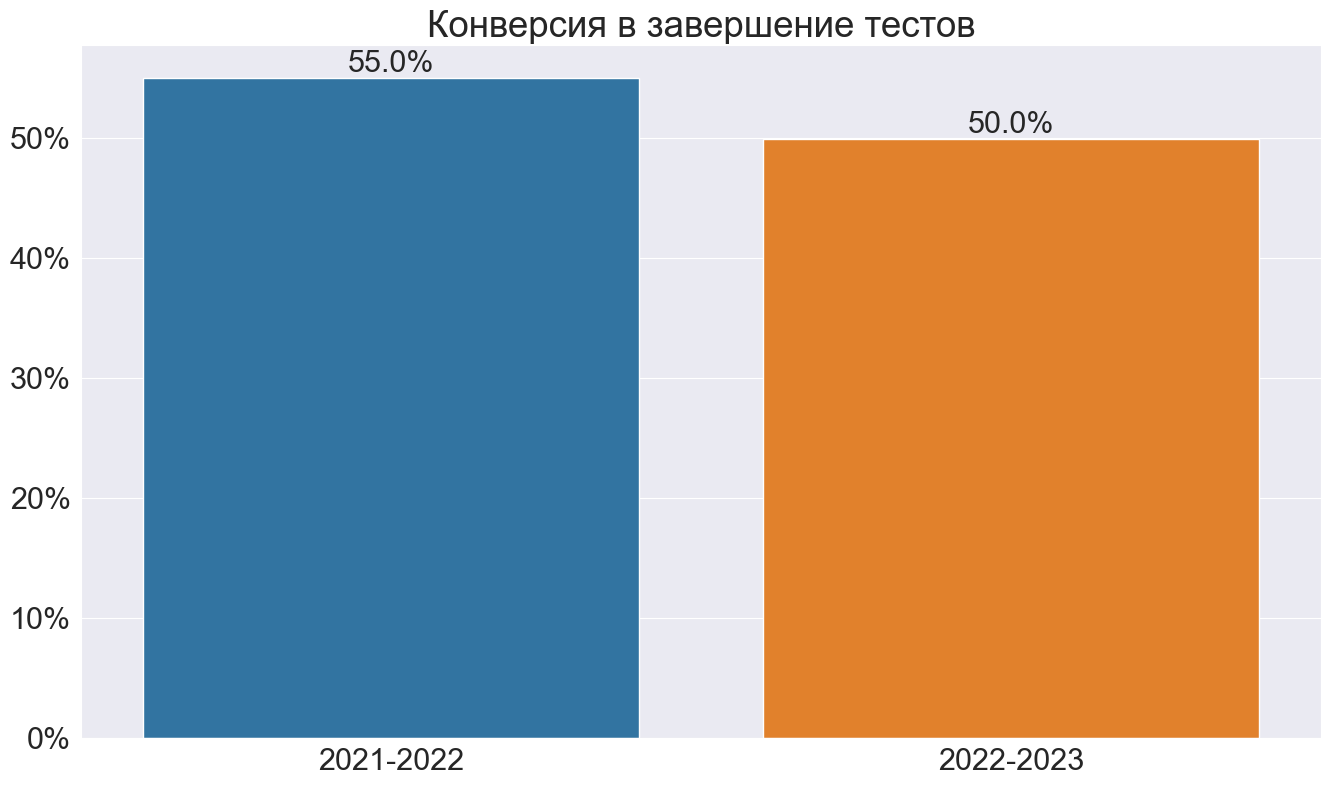

In [31]:
ax = sns.barplot(data=df, x='year', y='test_finished', ci=0)
ax.bar_label(ax.containers[0], labels=[f'{x.get_height():.1%}' for x in ax.containers[0]])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.set(title = 'Конверсия в завершение тестов', xlabel='', ylabel = '')
plt.show()

Попробуем поточнее оценить, является ли разница в доле тех, кто завершил тест критической. Для этого можно применить $Z$-тест на разницу долей.

$H_0$: доли завершивших тест равны в 2021-2022 и 2022-2023 годах

$H_1$: доли различны

In [32]:


def test_share_eq(df: pd.DataFrame, dep_col: str, ind_col: str, ALPHA: float):
    '''
    Функция получает на вход названия колонки зависимого параметра (того чью долю считаем)
    и независимого (того по которому группируем). Оба параметра должны быть булевы. Также
    на вход идет уровень значимости теста, ALPHA.
    
    Расчитывает необходимые доли и проводит Z-test на равенство долей с уровнем значимости ALPHA
    
    Печатает ALPHA, p-value и результат теста.
    '''
    group_size = df[ind_col].value_counts() #размер групп
    share_size = df.groupby(ind_col)[dep_col].sum() #размер целевых подгрупп в группах
   
    
    p = share_size / group_size #доли
    display(p)
    p_combined = share_size.sum() / group_size.sum() #общая доля
    # разница пропорций в датасетах
    difference = p[0] - p[1]
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_size[0] + 1/group_size[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Уровень значимости: {ALPHA}')
    print('p-значение: {0:.15f}'.format(p_value))

    if (p_value < ALPHA):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

test_share_eq(df,'test_finished', 'year', .05)

year
2021-2022    0.549655
2022-2023    0.499567
dtype: float64

Уровень значимости: 0.05
p-значение: 0.000000000000000
Отвергаем нулевую гипотезу: между долями есть значимая разница


Также проведем перестановочный тест с теми же гипотезами

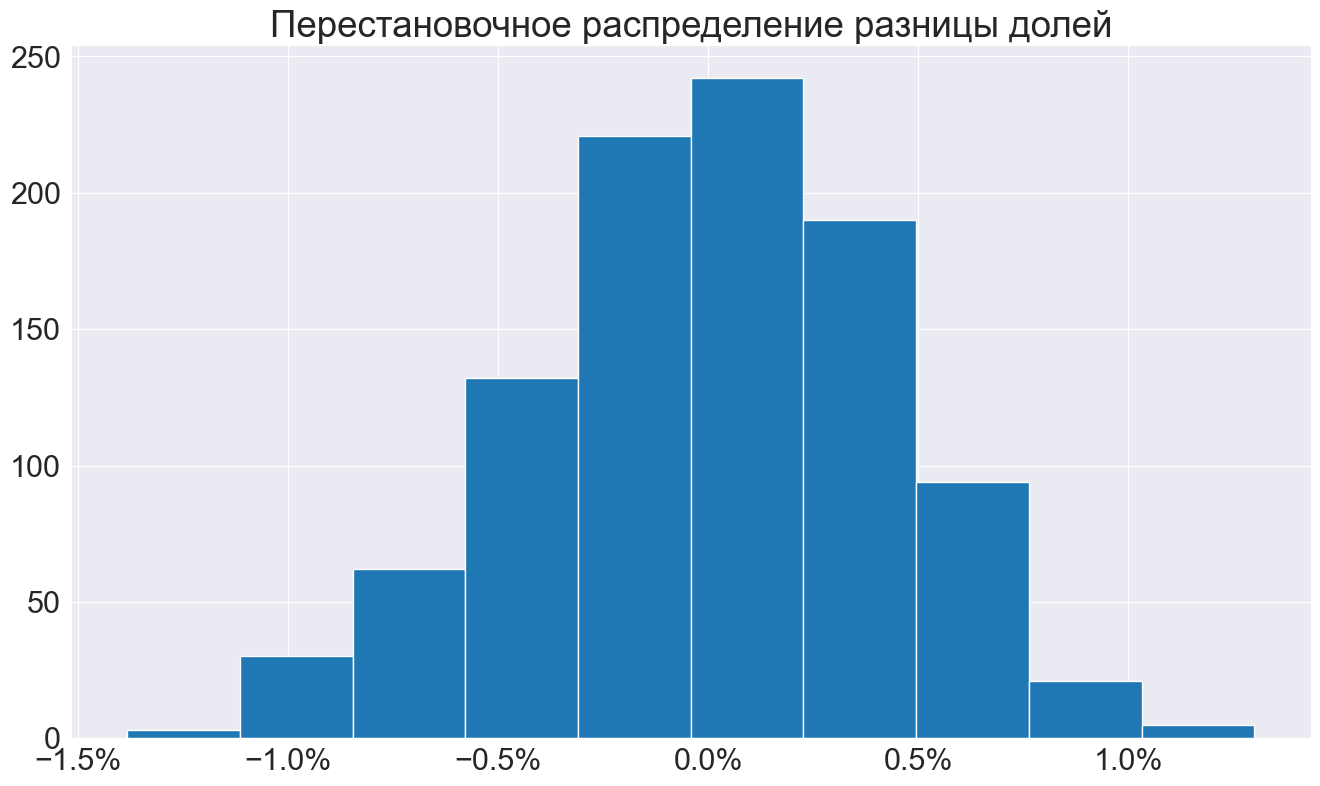

5-% перестановочный интервал: [-0.00873503  0.00769052]


In [33]:
def permutation_share(df, share_col, n_samples=1000, alpha=5):
    group_0_size = df[share_col].value_counts().sort_index().tolist()[0]
    diff_ls = []
    for _ in range(n_samples):
        shuffle = df[share_col].sample(frac=1, replace=False)
        share_0 = shuffle[:group_0_size].mean()
        share_1 = shuffle[group_0_size:].mean()
        diff = share_0 - share_1
        diff_ls.append(diff)
    fig, ax = plt.subplots(1, figsize=(16, 9))
    plt.hist(diff_ls)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))
    ax.set(title='Перестановочное распределение разницы долей')
    plt.show()
    
    print(f'{alpha}-% перестановочный интервал: {np.percentile(diff_ls, [alpha / 2, 100 - alpha / 2])}')

permutation_share(df, 'test_finished')

Мы видим, что наша разница в почти  5% находинтся далеко за границей интервала, т.е. эта разница значимая.

Мы видим, что как $Z$-тест на равенство долей, так и перестановочный тест демонстрируют, что разница у нас статистически значимая, т.е действительно доля завершивших тесты выше в 2021-2022 году

## <a id='toc4_2_'></a>[Даты](#toc0_)

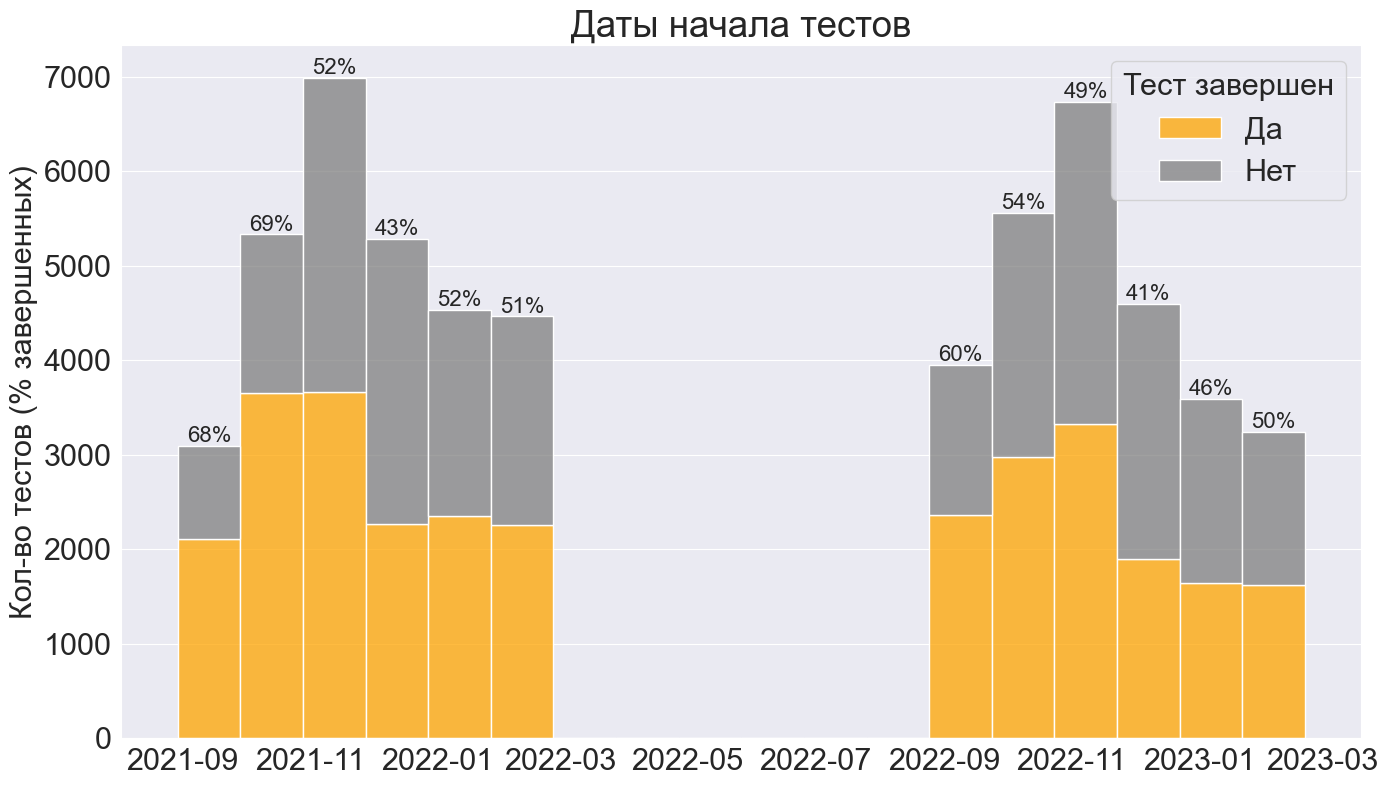

In [34]:
ax = sns.histplot(data=df, x='started_at', hue='test_finished', multiple='stack', palette=palette_dict, binwidth=30)
percents = [f'{x.get_height() / (x.get_height() + y.get_height()):.0%}' if x.get_height() != 0 else '' for x, y in zip(ax.containers[0], ax.containers[1])]
ax.bar_label(ax.containers[1], labels=percents, fontsize=16)
plt.legend(title='Тест завершен', loc='upper right', labels=['Да', 'Нет'])
ax.set(title='Даты начала тестов', xlabel='', ylabel='Кол-во тестов (% завершенных)')
plt.grid(axis='x')

- Почти на все даты процент завершенных тестов выше в 2021-2022 году
- Особенно большая разница в сентябре-октябре, около 10%. В последние месяцы она снизилась до 1-6%

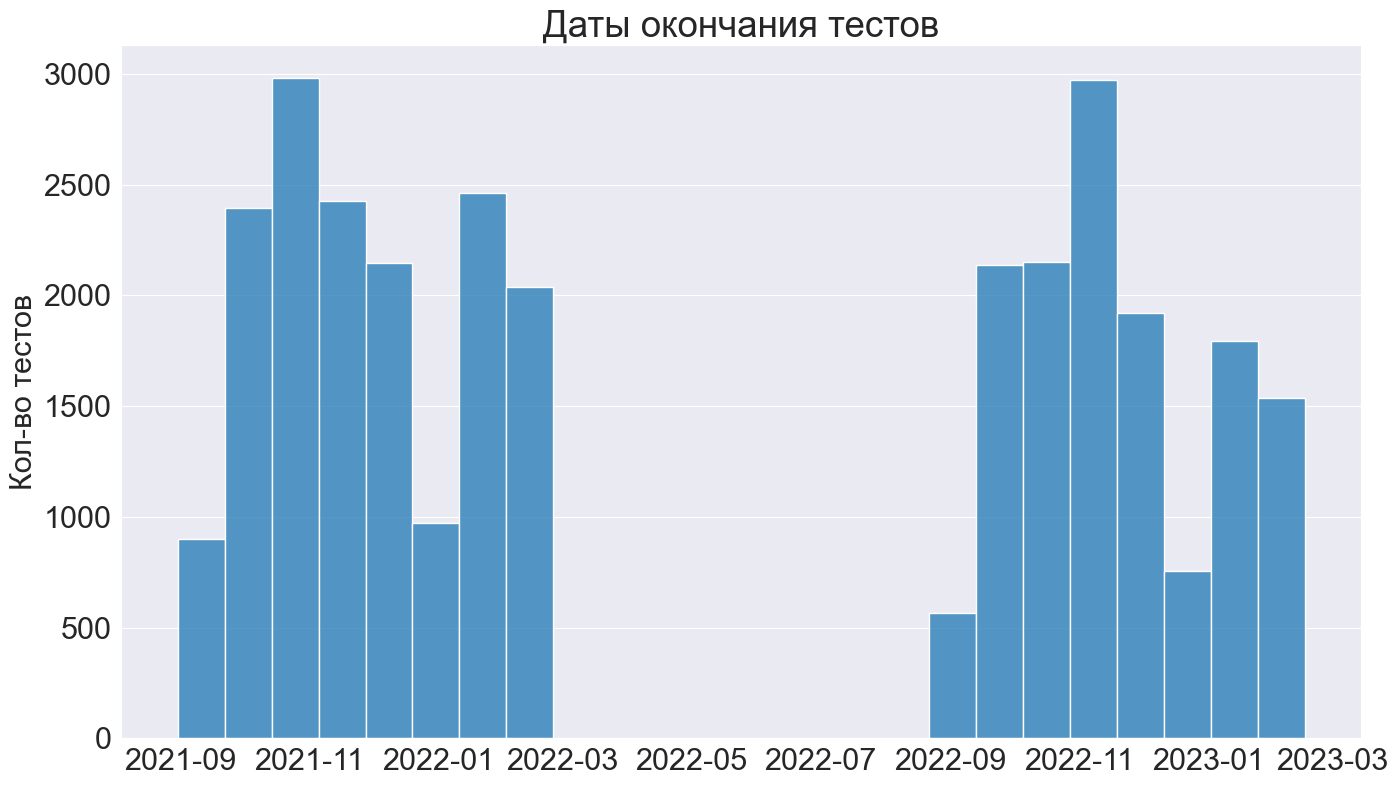

In [35]:
ax = sns.histplot(data=df, x='finished_at')
ax.set(title='Даты окончания тестов', xlabel='', ylabel='Кол-во тестов')
plt.grid(axis='x')

## <a id='toc4_3_'></a>[Триггерные группы](#toc0_)

<AxesSubplot:xlabel='year', ylabel='days_to_finish'>

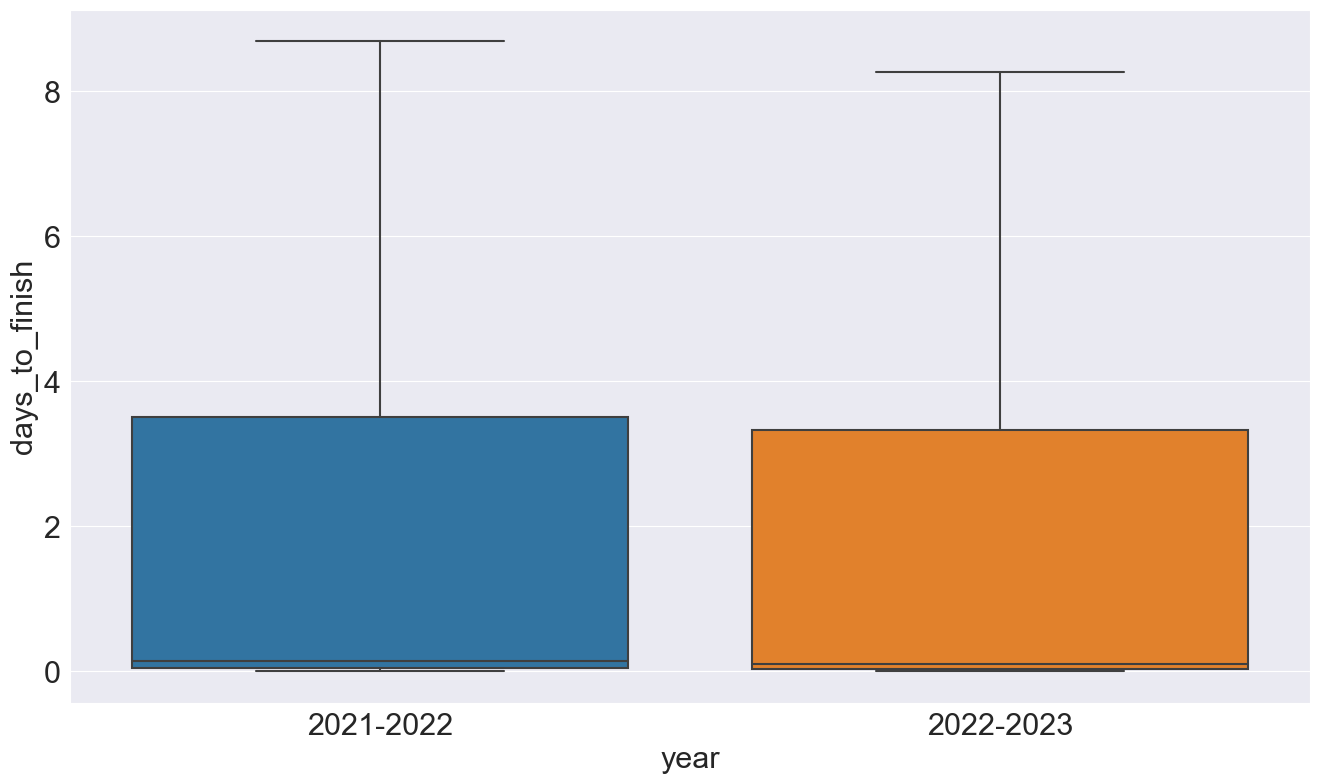

In [36]:
df['days_to_finish'] = (df['finished_at'] - df['started_at']) / np.timedelta64(1, 'D')
sns.boxplot(data=df, y='days_to_finish', x='year', showfliers=False)
#plt.ylim((0,16))

Также необходимо также добавить граничное время, по которому мы сделали срез данных

In [37]:
df['max_date'] = pd.Timestamp('2022-' + DATE_END)
df.loc[df['year'] == '2022-2023', 'max_date'] = pd.Timestamp('2023-' + DATE_END)
df['max_date_diff'] = (df['max_date'] - df['started_at']) / np.timedelta64(1, 'D')
df.loc[df['test_finished'] == 1, 'max_date_diff'] = np.nan
df

,year,id,test_finished,started_at,finished_at,days_to_finish,max_date,max_date_diff
28688,2021-2022,1901,1,2021-09-11 13:39:46,2021-11-04 18:48:15.666,54.214232,2022-02-16 16:51:00,NaN
38243,2021-2022,32251,1,2021-11-05 15:40:22,2021-11-05 16:01:19.341,0.014553,2022-02-16 16:51:00,NaN
38244,2021-2022,32256,1,2021-11-05 15:45:32,2021-11-07 14:50:56.518,1.962089,2022-02-16 16:51:00,NaN
38245,2021-2022,32262,1,2021-11-05 15:50:41,2021-11-06 18:37:04.009,1.115544,2022-02-16 16:51:00,NaN
38246,2021-2022,32263,1,2021-11-05 15:50:44,2021-11-22 19:03:10.017,17.133634,2022-02-16 16:51:00,NaN
...,...,...,...,...,...,...,...,...
18460,2022-2023,27556,0,2022-12-04 14:05:02,NaT,NaN,2023-02-16 16:51:00,74.115255
18461,2022-2023,27557,0,2022-12-04 14:07:26,NaT,NaN,2023-02-16 16:51:00,74.113588
18462,2022-2023,27558,1,2022-12-04 14:10:33,2022-12-04 22:05:58.000,0.330150,2023-02-16 16:51:00,NaN
18451,2022-2023,27545,0,2022-12-04 13:35:42,NaT,NaN,2023-02-16 16:51:00,74.135625


[Text(0.5, 1.0, 'Распределение тестов по триггерным группам'),
 Text(0.5, 0, 'Кол-во триггеров'),
 Text(0, 0.5, 'Кол-во тестов')]

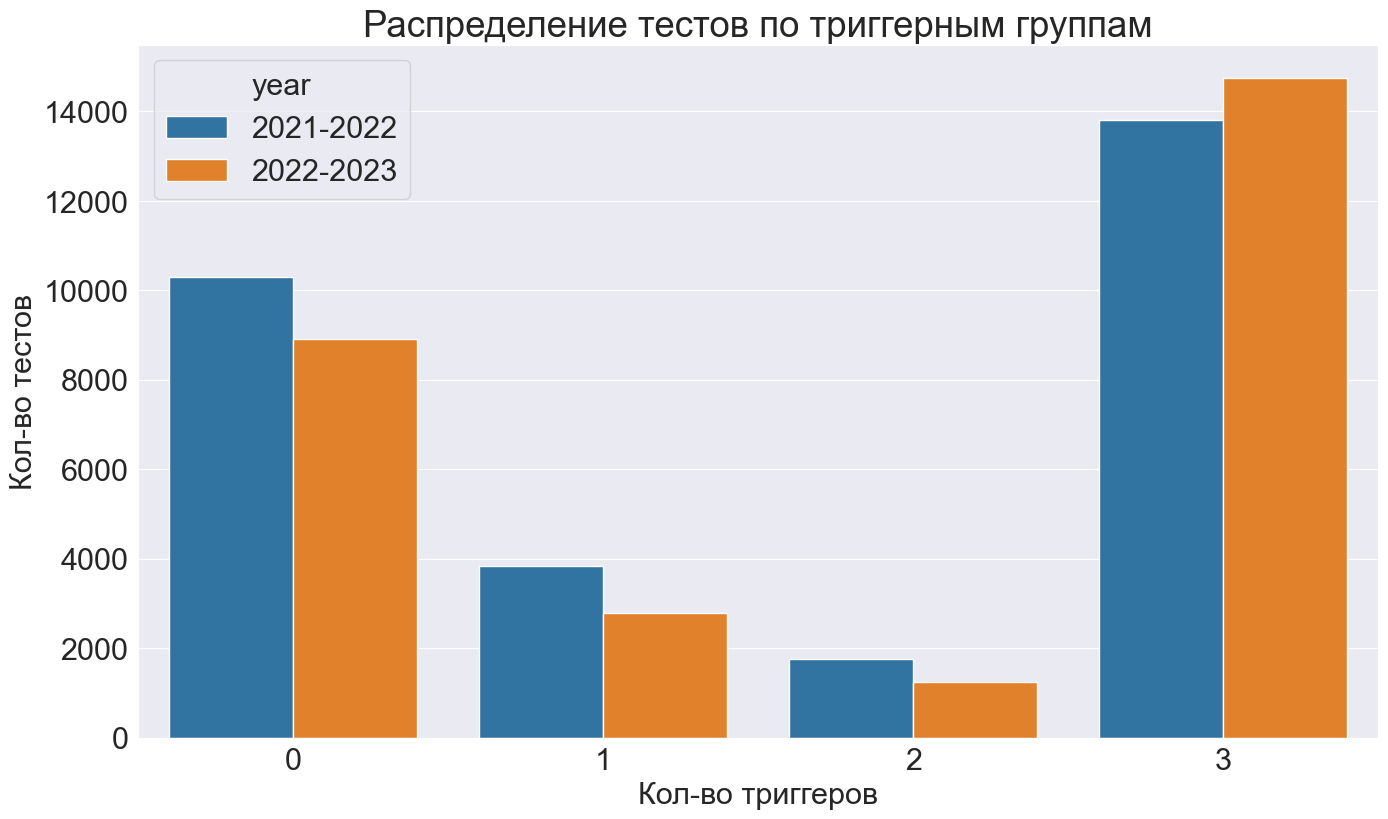

In [38]:
df['trigger_cnt'] = 3
df.loc[(df['days_to_finish'] < 1) | (df['max_date_diff'] < 1), 'trigger_cnt'] = 0
df.loc[((1 <= df['days_to_finish']) & (df['days_to_finish'] < 7)) | ((1 <= df['max_date_diff']) & (df['max_date_diff'] < 7)), 'trigger_cnt'] = 1 
df.loc[((7 <= df['days_to_finish']) & (df['days_to_finish'] < 14)) | ((7 <= df['max_date_diff']) & (df['max_date_diff'] < 14)), 'trigger_cnt'] = 2
ax = sns.countplot(data=df, x='trigger_cnt', hue='year')
ax.set(title='Распределение тестов по триггерным группам', xlabel='Кол-во триггеров', ylabel='Кол-во тестов')

## <a id='toc4_4_'></a>[Завершившие тест](#toc0_)

Посмотрим, как завершившие тест распределяются по триггерным группам

In [39]:
finished_cnt = df.groupby(['year','trigger_cnt'])['test_finished'].sum()
finished_cnt

year       trigger_cnt
2021-2022  0              10232
           1               3045
           2               1055
           3               1990
2022-2023  0               8892
           1               2396
           2                827
           3               1714
Name: test_finished, dtype: int64

In [40]:
finished_cnt.sum(level=0)

year
2021-2022    16322
2022-2023    13829
Name: test_finished, dtype: int64

In [41]:
finished_percent = (finished_cnt / finished_cnt.sum(level=0)).reset_index()
finished_percent

,year,trigger_cnt,test_finished
0,2021-2022,0,0.626884
1,2021-2022,1,0.186558
2,2021-2022,2,0.064637
3,2021-2022,3,0.121921
4,2022-2023,0,0.642997
5,2022-2023,1,0.173259
6,2022-2023,2,0.059802
7,2022-2023,3,0.123942


In [42]:
def barplot_binary_percent(data: pd.DataFrame, x: str, y: str, 
    title=None, xlabel=None, ylabel=None, palette='tab10',
    hue: str=None, ticklabels: list=None, 
    hue_legend_labels: list=None, hue_legend_title: str=None):

    ax = sns.barplot(data=data, x=x, y=y, hue=hue, ci=0, palette=palette)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

    if ticklabels:
        ax.set_xticklabels(ticklabels)

    if hue_legend_labels:
        handles, labels = ax.get_legend_handles_labels()
        labels = hue_legend_labels
        ax.legend(handles, labels, title=hue_legend_title)
    if title or xlabel or ylabel:
      ax.set(title=title, xlabel=xlabel, ylabel=ylabel)

    if hue:
      hue_size = data[hue].nunique()
      for i in range(hue_size):
        ax.bar_label(ax.containers[i], labels = [f'{x.get_height():.1%}' for x in ax.containers[i]])
    else:
      ax.bar_label(ax.containers[0], labels = [f'{x.get_height():.1%}' for x in ax.containers[0]])
    return ax

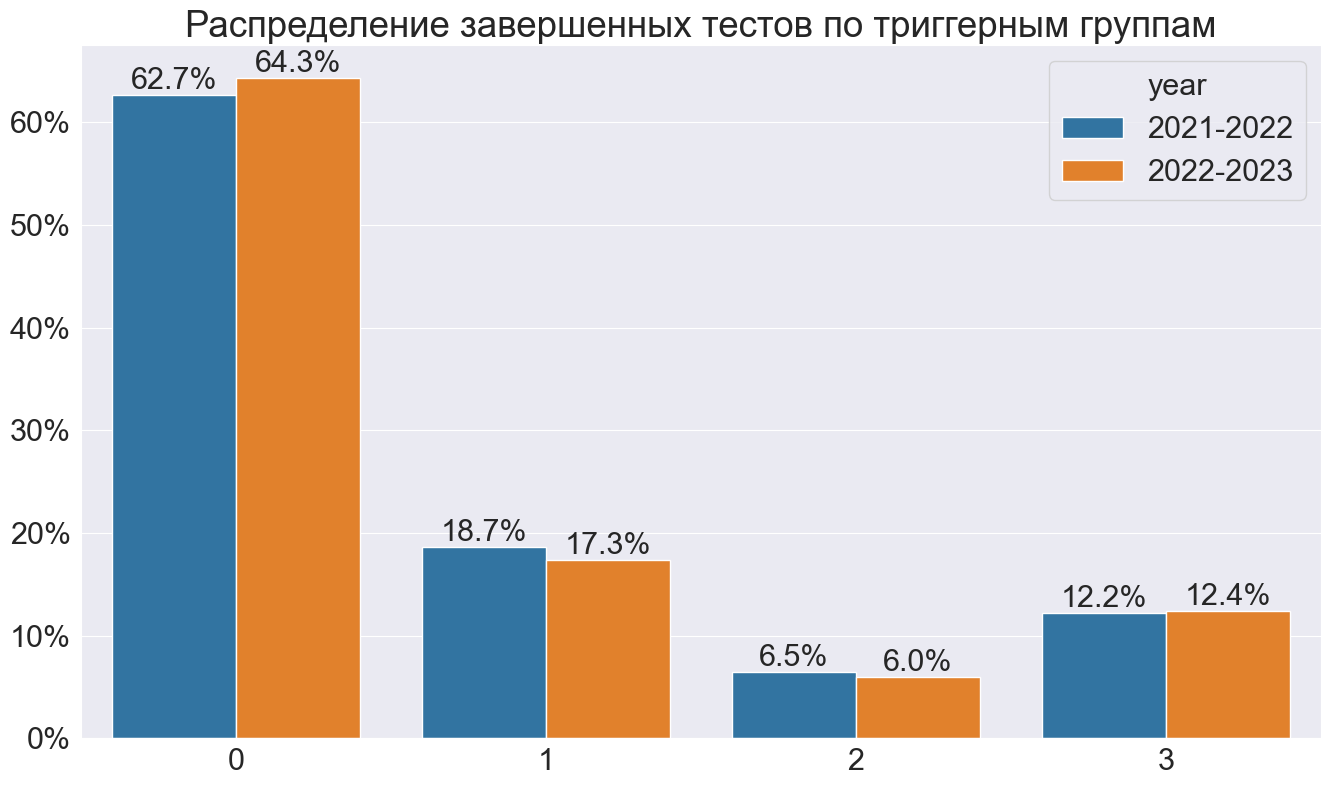

In [43]:
barplot_binary_percent(data=finished_percent, x='trigger_cnt', y='test_finished', hue='year',
    title = 'Распределение завершенных тестов по триггерным группам', xlabel='', ylabel='')
plt.show()

Видим, что в 2021-2022 учебном году несколько больший процент завершенных тестов был завершен после 1 или 2х триггерных напоминаний, причем разница произошла за счет тех, кто завершил без триггеров.

Попробуем поточнее оценить, является ли разница в доле тех, кто завершил без триггеров критической. Для этого можно применить $Z$-тест на разницу долей.

$H_0$: доли тех, кто попадает в триггерные группы 1-3, среди завершивших тест равны в 2021-2022 и 2022-2023 годах

$H_1$: доли различны

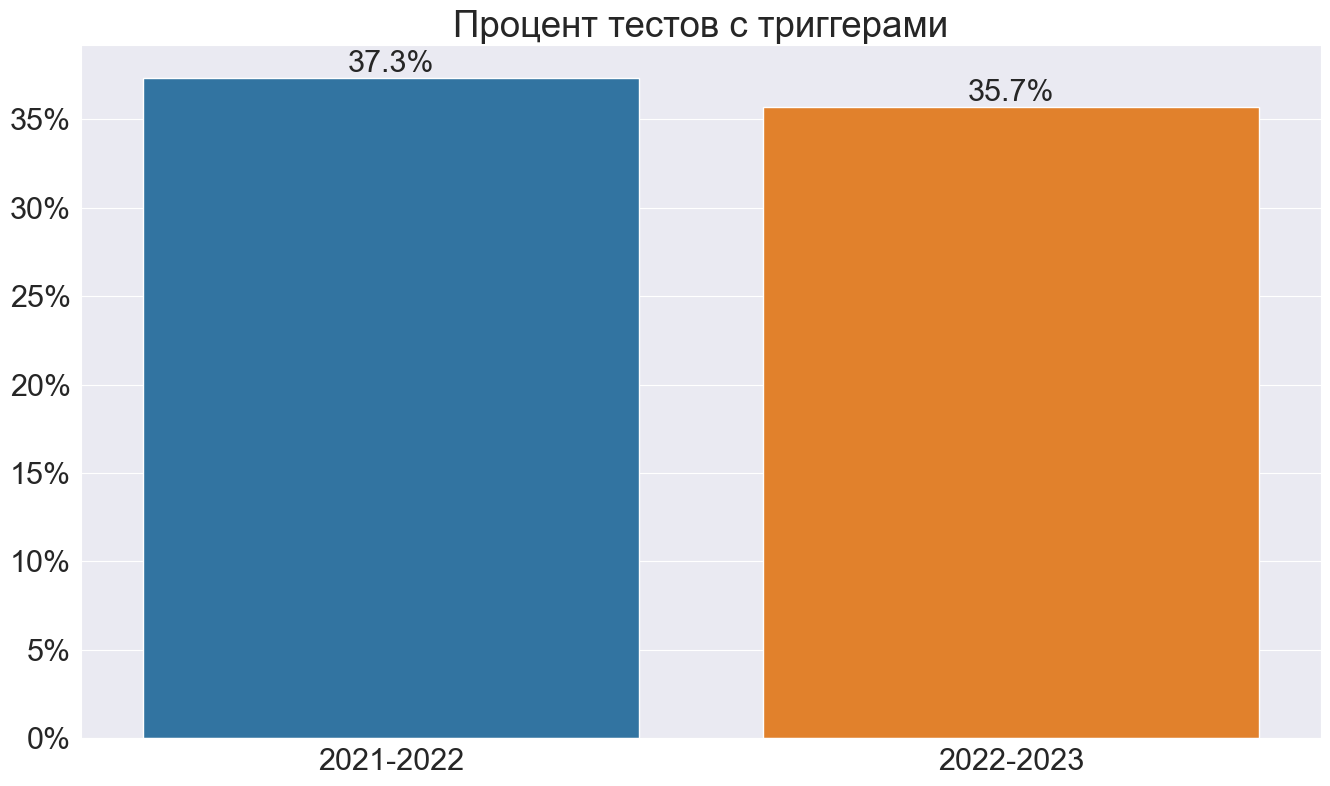

In [44]:
df['is_triggered'] = 0
df.loc[df['trigger_cnt'] > 0 , 'is_triggered'] = 1

df_finished = df[df['test_finished'] == 1].copy()
barplot_binary_percent(data=df_finished.sort_values(by='year'), x='year', y='is_triggered',
    title='Процент тестов с триггерами', xlabel='', ylabel='', palette='tab10')
plt.show()

In [45]:


def test_share_eq(df: pd.DataFrame, dep_col: str, ind_col: str, ALPHA: float):
    '''
    Функция получает на вход названия колонки зависимого параметра (того чью долю считаем)
    и независимого (того по которому группируем). Оба параметра должны быть булевы. Также
    на вход идет уровень значимости теста, ALPHA.
    
    Расчитывает необходимые доли и проводит Z-test на равенство долей с уровнем значимости ALPHA
    
    Печатает ALPHA, p-value и результат теста.
    '''
    group_size = df[ind_col].value_counts().sort_index() #размер групп
    group_size.index.name = ind_col
    
    share_size = df.groupby(ind_col)[dep_col].sum().sort_index() #размер целевых подгрупп в группах
   
    
    p = share_size / group_size #доли
    display(p)
    p_combined = share_size.sum() / group_size.sum() #общая доля
    # разница пропорций в датасетах
    difference = p[0] - p[1]
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_size[0] + 1/group_size[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Уровень значимости: {ALPHA}')
    print('p-значение: {0:.15f}'.format(p_value))

    if (p_value < ALPHA):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

test_share_eq(df_finished,'is_triggered', 'year', .05)

year
2021-2022    0.373116
2022-2023    0.357003
dtype: float64

Уровень значимости: 0.05
p-значение: 0.003796979442433
Отвергаем нулевую гипотезу: между долями есть значимая разница


Таким образом, $Z$-тест с уровнем значимости 5% говорит о том, что гипотеза о равенстве долей тестов, в которых были получены триггерные сообщения, неверна.

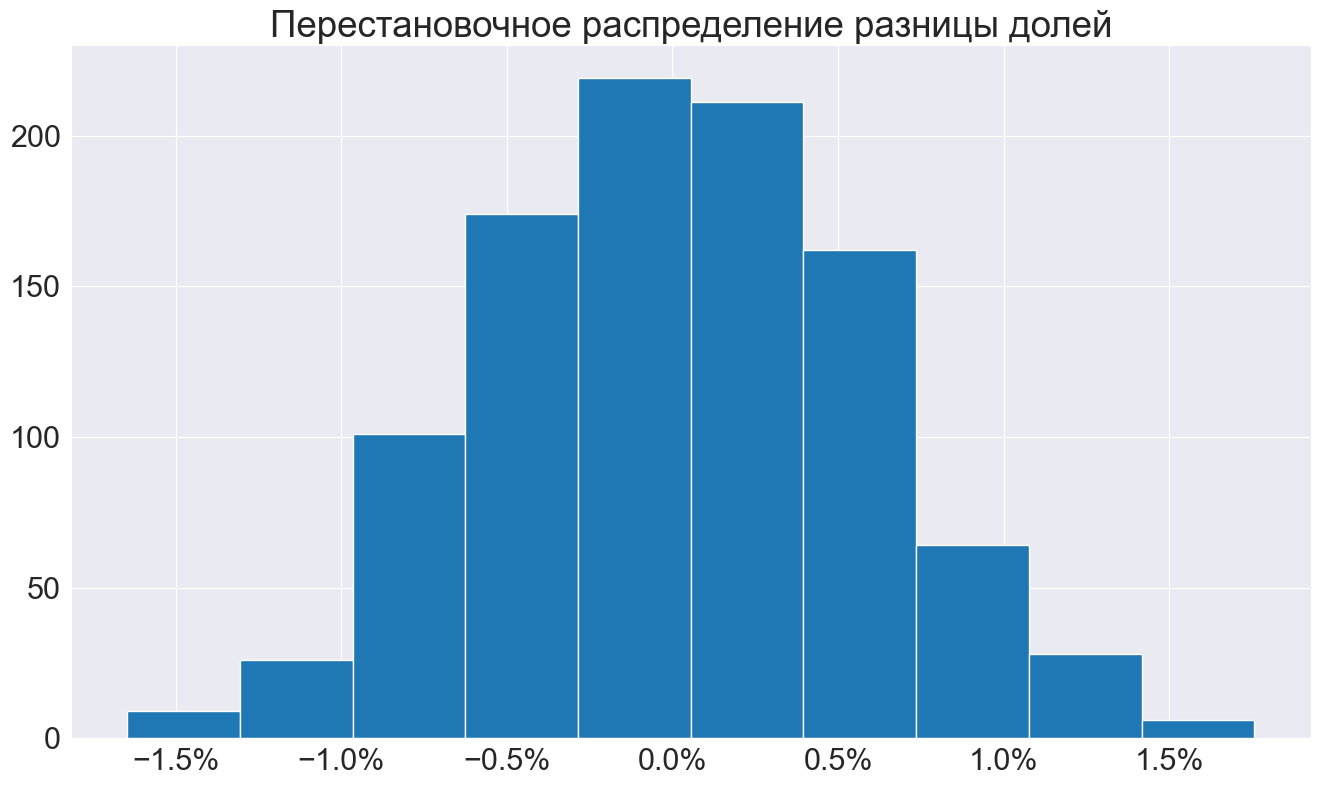

5-% перестановочный интервал: [-0.01032165  0.01156095]


In [46]:
permutation_share(df_finished, 'is_triggered')

Перестановочный тест также показывает, что наша разница в почти 2% лежит за границей доверительной интервала, т.е. она критическая.

## <a id='toc4_5_'></a>[Конверсия по триггерам](#toc0_)

Теперь посмотрим на нашу задачу с точки зрения конверсии из начавших тест в завершивших и проанализируем, как эта конверсия распределяется по триггерным группам

Посмотрим на конверсию в завершение тех, для кого прошло больше суток с момента начала теста, т.е. тех кто в 2021-2022 году получил триггерные рассылки.

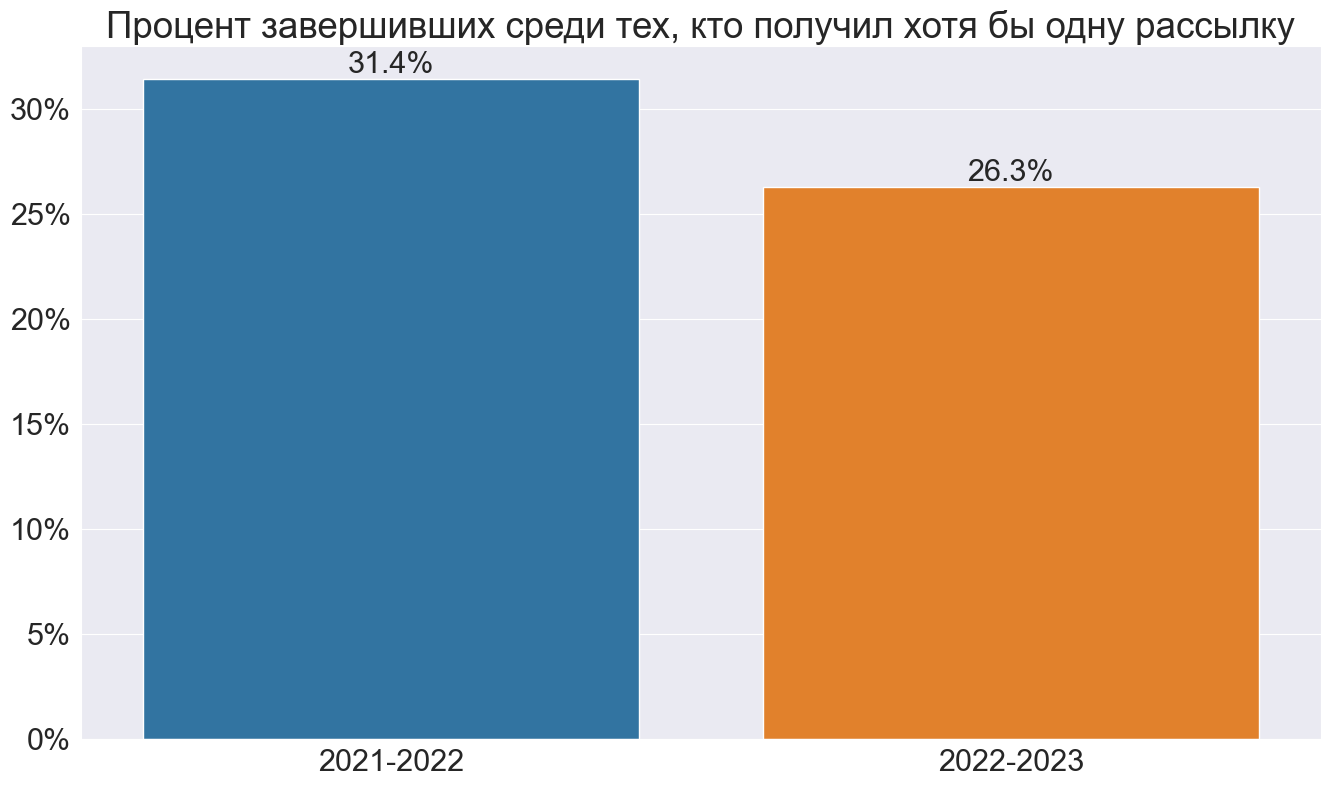

In [47]:
ax = barplot_binary_percent(data=df[df['is_triggered'] == 1].sort_values(by='year'), x='year', y='test_finished',
    title='Процент завершивших среди тех, кто получил хотя бы одну рассылку')

Видим, что у нас большая разница по проценту конверсии среди тех тестов, у которых прошло более суток с момента начала теста: 31.4% и 26.3%.

Также можем посмотреть на то, в какой момент конвертируются ученики:

In [48]:
started_cnt = df['year'].value_counts()
started_cnt.index.name = 'year'
started_cnt

year
2021-2022    29695
2022-2023    27682
Name: year, dtype: int64

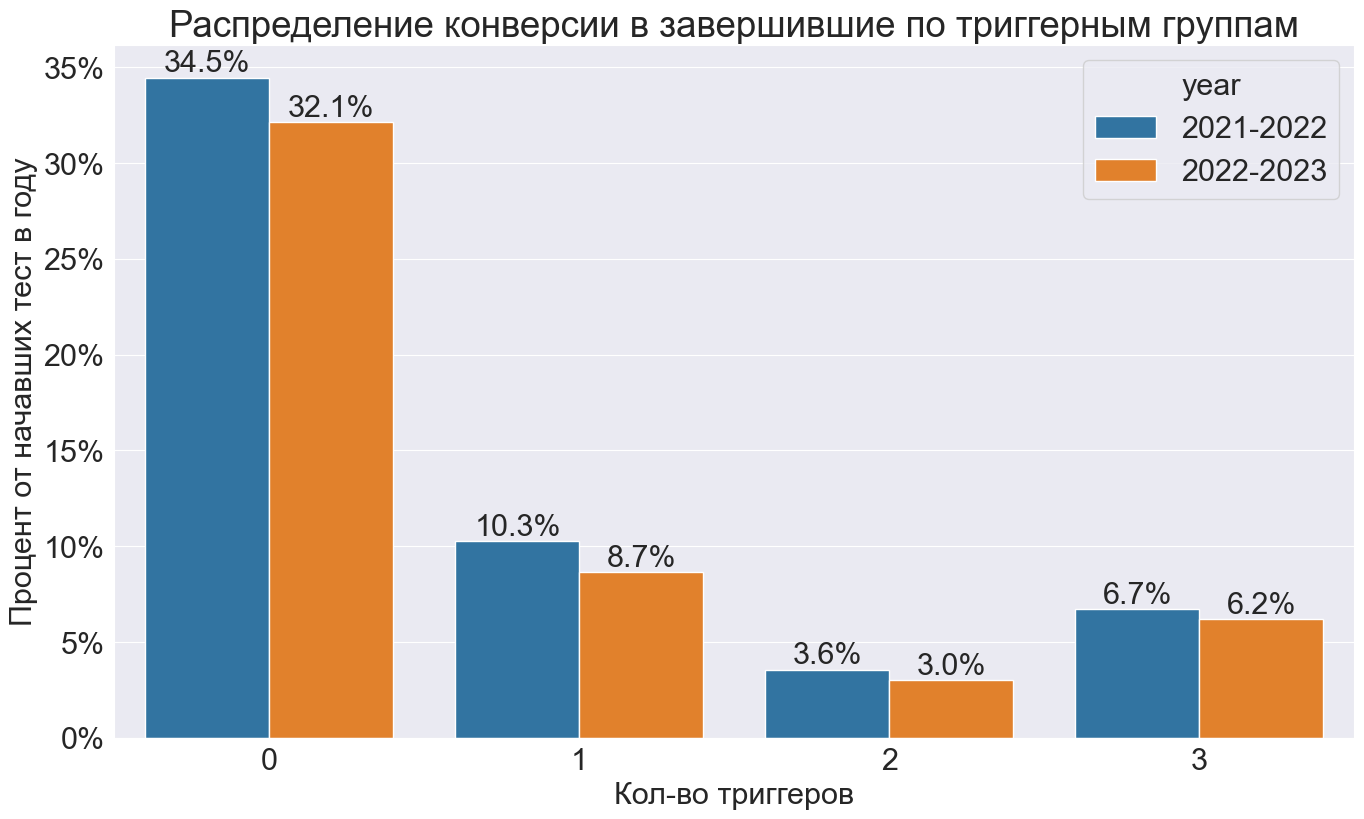

In [49]:
finished_percent_conv = (finished_cnt / started_cnt).reset_index()
ax = barplot_binary_percent(data=finished_percent_conv, x='trigger_cnt', y=0, hue='year',
    title='Распределение конверсии в завершившие по триггерным группам', xlabel='Кол-во триггеров', ylabel='Процент от начавших тест в году')
plt.show()

Тут мы видим, что конверсия выше в 2021-2022 году во всех триггерных группах, включая и ту группу, где ученики завершили тест до получения триггерной рассылки. Это говорит о том, что помимо триггеров вполне возможно, что конверсия в 2021-2022 году выше под влиянием других факторов или же речь идет естественной вариации данных.

Попробуем сделать $Z$-тест, чтобы точнее оценить последнее утверждение в контексте вариативности данных

In [50]:


def test_share_eq_extra(df: pd.DataFrame, dep_col: str, ind_col: str, query, ALPHA: float):
    '''
    Функция получает на вход названия колонки зависимого параметра (того чью долю считаем)
    и независимого (того по которому группируем). Оба параметра должны быть булевы. Также
    на вход идет уровень значимости теста, ALPHA.
    
    Расчитывает необходимые доли и проводит Z-test на равенство долей с уровнем значимости ALPHA
    
    Печатает ALPHA, p-value и результат теста.
    '''
    group_size = df[ind_col].value_counts().sort_index() #размер групп
    group_size.index.name = ind_col
    
    share_size = df.query(query).groupby(ind_col)[dep_col].sum().sort_index() #размер целевых подгрупп в группах
    
    p = share_size / group_size #доли
    display(p)
    p_combined = share_size.sum() / group_size.sum() #общая доля
    # разница пропорций в датасетах
    difference = p[0] - p[1]
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_size[0] + 1/group_size[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Уровень значимости: {ALPHA}')
    print('p-значение: {0:.15f}'.format(p_value))

    if (p_value < ALPHA):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

test_share_eq_extra(df,'test_finished', 'year', 'is_triggered == 0', .05)

year
2021-2022    0.34457
2022-2023    0.32122
dtype: float64

Уровень значимости: 0.05
p-значение: 0.000000003048644
Отвергаем нулевую гипотезу: между долями есть значимая разница


Это говорит о том, что разница в долях завершивших и не получивших триггеров скорее всего не случайна, т.е. __имеют место дополнительные факторы влияющие на конверсию__.

# <a id='toc5_'></a>[Вывод](#toc0_)

- Общая конверсия в завершение тестов существенно различается по годам (55% в 2021-2022 против 50% в 2022-2023). Статистическая значимость подтверждается $Z$-тестом на равенство долей, а также перестановочным тестом.

- Разница в конверсии достигает максимального значения (почти 10%) для тестов начатых в первые месяцы учебного года, затем плавно снижается до 1% в конце январе - начале февраля.

- Процент завершенных тестов, в которых прошли хотя бы сутки с момента начала до окончания, статистически значимо выше в 2021-2022 году. По таким тестам в 2021-2022 году рассылались напоминания. Опять же это подтвержает Z-тест на равенство долей и перестановочный тест. Возможно это свидетельствует о том, что триггерные рассылки имели некоторый эффект.

- Конверсия в завершение в группе тестов, для которых прошло хотя бы сутки с момента начала до окончания или до 16.02, существенно выше в 2021-2022 году (31.4% против 26.3%).

- В то же время конверсия из начавших в завершенные выше в 2021-2022 году во всех триггерных группах, включая нулевую. Разница в конверсии в нулевую группу статистически значима, что показывает Z-тест. Это говорит о том, что и в тестах, где рассылок не было, конверсия выше в 2021-2022 году, а значит имели место какие-то еще факторы, влияющие на конверсию помимо рассылок.

# <a id='toc6_'></a>[Дальнейшие исследования](#toc0_)

- Посмотреть те же статистики в разрезе классов и предметов